# TP IOT: Prédiction de la localisation

**La solution répandue pour identifier la position d'un périphérique à partir de base qui le détecte est la triangulation. Pour des périphériques très légers, ce type de prédiction est onéreux comparé à un modèle de machine learning, ce qui rend son intégration moins polyvalente.**

# Import package

**Si vous ne possedez pas les packages pour la visualisation Décommenter les lignes suivants.**

In [1]:
import sys
envs = !conda env list
active_env = list(filter(lambda s: '*' in str(s), envs))[0]
env_name = str(active_env).split()[0]
print( env_name)
#=======================================================================
# DASH
#! pip install plotly
#! pip install dash
#! pip install dash-html-components
#! pip install dash-core-components
#! pip install dash-table
#
# Visualisation de dash dans jupyter
#
#! pip install aiohttp
#! pip install django_plotly_dash
#! pip install jupyter_plotly_dash
#
# Autre
#
#!pip install  geopy
print("fin d'installation ")
# Set credential
import plotly
plotly.tools.set_credentials_file(username='telecommsbgd2', api_key='vycTMoJ16qDZEdUWiOiC')

python36
fin d'installation 


In [2]:
#Package classique
import numpy as np
import pandas as pd
import datetime


# calcul de distance
from geopy.distance import vincenty


#Package affichage
from jupyter_plotly_dash import JupyterDash
import dash
from dash.dependencies import Input, Output,State
import dash_core_components as dcc
import dash_html_components as html
from datetime import datetime as dt
import dash_table as dtt
import plotly.graph_objs as go
import multiprocessing
import matplotlib.pyplot as plt



# Package machine learning
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import Pipeline
from pprint import pprint
from time import time
#from spark_sklearn import GridSearchCV
from sklearn.metrics import make_scorer

# Lecture du dataset

In [3]:
df_mess_train = pd.read_csv('https://raw.githubusercontent.com/osans-tel/Geoloc/master/mess_train_list.csv')
df_mess_test = pd.read_csv('https://raw.githubusercontent.com/osans-tel/Geoloc/master/mess_test_list.csv')
pos_train = pd.read_csv('https://raw.githubusercontent.com/osans-tel/Geoloc/master/pos_train_list.csv')

**Pour la partie exploration, Nous allons maintenant joindre** ```pos_train``` **et** ```def_mess_train``` **et les stocker dans la table** ```df``` **. Nous allons aussi créer la table** ```bsid_tab``` **qui comportera la position de chaque base pour acceler la présentation.**

In [4]:
df = df_mess_train.merge(pos_train, how='left', left_index=True,right_index=True)
# On enleve les valeurs abérente pour la visualisation
df = df.drop(df[(df.bs_lng >55) ].index)

In [5]:
# Récuperation des bsid sur le jeu de train
basepos = df_mess_train[['bsid','bs_lat','bs_lng']]\
    .groupby(by='bsid')\
    .agg({'bs_lat':'mean','bs_lng':'mean'})\
    .sort_index()\
    .reset_index(drop=False)
#Récuperation des bsid sur le jeu de test
basepos2 = df_mess_test[['bsid','bs_lat','bs_lng']]\
    .groupby(by='bsid')\
    .agg({'bs_lat':'mean','bs_lng':'mean'})\
    .sort_index()\
    .reset_index(drop=False)

On merge les deux bases, puis on caste bsid au bon format (numérique). On supprime les redondances et redéfinit l'index pour avoir une table propre

In [6]:
bsid_tab=basepos.append(basepos2, ignore_index=True)
bsid_tab['bsid']=pd.to_numeric(bsid_tab.bsid.values)
bsid_tab.drop_duplicates(subset='bsid',inplace=True)
bsid_tab.reset_index(drop=False)
print(bsid_tab.head())
bsid_tab.describe()

   bsid     bs_lat      bs_lng
0   879  39.739013 -105.392793
1   911  42.324279 -107.159505
2   921  42.131222 -107.008741
3   944  41.424900 -106.143919
4   980  38.997730 -104.684275


,bsid,bs_lat,bs_lng
count,259.000000,259.000000,259.000000
mean,4520.640927,42.671160,-100.916437
std,2728.008223,7.788961,11.559526
min,879.000000,36.053394,-110.957181
25%,2767.000000,39.697472,-105.112058
50%,3568.000000,39.805420,-105.001415
75%,7641.500000,40.082703,-104.818705
max,11951.000000,64.300000,-68.500000


# Exploration des données

Afin d'effectuer une exploration dynamique et intuitive, observons au travers d'un dashboard nos données

In [13]:
app = JupyterDash('Visualisation donnée gps')
app.width="1300px"
app.height="900px"

# fonction et application pour la visualisation 
def getdid(dff):
    did=[]
    for val in dff.did.unique():
        tmp={}
        tmp['label']=val
        tmp['value']=val
        did.append(tmp)
    
    return did
df['time']=pd.to_datetime(df.time_ux, unit='ms')
df['text']=" Date "+df["time"].map(str)+" Message ID " + df["messid"].astype(str)

mapbox_access_token = 'pk.eyJ1IjoiY2h1emUiLCJhIjoiY2pxMHRsY3IzMG9lMjQ4cWprZWJkZTBxMiJ9.gKc50IpMQM2e4skq2NskHw'
app.layout = html.Div([
    html.Link(href='https://maxcdn.bootstrapcdn.com/bootstrap/3.3.7/css/bootstrap.min.css',rel='stylesheet'),
    html.Div(className="row",children=[
        html.Div(className="col-sm-10",children=[
            dcc.Graph(id='visualisation'),
            html.Div(className="row",children=[
                html.Div(className="col-sm-7",children=[
                    dcc.Graph(id='visualisation2'),
                ]),
                html.Div(className="col-sm-5",children=[
                    html.H2("Device ID"),
                    dcc.Dropdown(
                        id='devicesID',
                        options=getdid(df),
                        multi=True,
                        value=df.did[0]
                    ),
                    html.Div([
                    ],id='test'),
                    html.P('Pour mettre à jour le second graphe clicker sur un point sur la carte de positionnement des devices')
                ])
            ]),
        ]),
        html.Div(className="col-sm-2",children=[
            html.Div([
                dcc.RangeSlider(
                    id='timechoice',
                    count=1,
                    min=-5,
                    max=10,
                    step=0.5,
                    value=[-3, 7]
                )
            ],id='choixslider',style={'height':'95vh','width':'100%','margin-top':'2.5vh'}),
        ])
    ])
])

# maj du slider temporel
@app.callback(
    Output('choixslider', 'children'),
    [Input('devicesID','value')]
)
def range_time(typeD):
    #calcul lie au composant
    q=""
    if type(typeD)==list:
        for device in typeD[:-1]:
            q+=" did =='"+str(device)+"' or "
        q+="did =='"+str(typeD[-1])+"'"
    else:
        q+="did =='"+str(typeD)+"'"
    rq=df.query(q)
    n = len(rq.time_ux.unique())
    # "beaute du slider"
    mark={}
    step_dot=int(n/10.0)
    for nn in range(n):
        if nn%step_dot==0:
            print(nn)
            print(rq.time.astype(str).unique()[nn])
            mark[str(nn)]=rq.time.astype(str).unique()[nn]
    mark[n]=rq.time.astype(str).unique()[n-1]
    # mise en place du composant
    return [dcc.RangeSlider(
        id='timechoice',
        min=0,
        max=n,
        vertical=True,
        marks=mark,
        value=[int(n*0.25),int(n*0.75)]
    )]
    

#Maj du graph principale
@app.callback(
    dash.dependencies.Output('visualisation', 'figure'),
    [Input('timechoice', 'value'),
     Input('devicesID','value')])
def update_vis(timechoice,DID):
    # requettage sur table des devices à afficher sur une période choisie
    q=""
    if type(DID)==list:
        for device in DID[:-1]:
            q+=" did =='"+str(device)+"' or "
        q+="did =='"+str(DID[-1])+"'"
    else:
        q+="did =='"+str(DID)+"'"
    devicefil = df.query(q)

    tux_unique = list(devicefil.time_ux.unique())
    q2=""
    if type(timechoice)==list:
        timee=tux_unique[timechoice[0]:timechoice[1]]
        q2+="time_ux>="+str(min(timee))+" and time_ux<="+str(max(timee))
    else:
        timee=tux_unique[timechoice]
        q2+="time_ux=="+str((timee))
    selection=devicefil.query(q2)
    
    # mise en conformite du device ID
    if type(DID)!=list:
        valnum=DID
        DID=[]
        DID.append(valnum)
        
    # display des bases de geolocalisation
    traces = []
    traces.append(go.Scattermapbox(
        lat=bsid_tab.bs_lat.values,
        lon=bsid_tab.bs_lng.values,
        mode='markers',
        name="Stations",
        opacity=0.7,
        marker = dict(
            symbol="information"
        ),
        text=basepos.index.values
        ))
        
    # display des devices
    for deviceID in DID:
        traces.append(go.Scattermapbox(
            lat=selection[(selection.did==deviceID)].lat.values,
            lon=selection[(selection.did==deviceID)].lng.values,
            mode='markers',
            opacity=0.7,
            marker = dict(
                size = 10,
            ),
            name=deviceID,
            text=selection[(selection.did==deviceID)].text.values,
        ))

    # Design
    layout = dict(
        title = 'Positionnement des devices',
        showlegend = True,
        mapbox=dict(
            accesstoken=mapbox_access_token,
            bearing=0,
            center=dict(
                lat=np.mean(selection.lat.values),
                lon=np.mean(selection.lng.values)
            ),
            pitch=0,
            zoom=9
        ),
        margin={'l': 10, 'b': 10, 't': 30, 'r': 10},

    )
    return {
        'data': traces,
        'layout': layout
    }

# Maj du second graph via message id
@app.callback(
    dash.dependencies.Output('visualisation2', 'figure'),
    [Input('visualisation', 'clickData')])
def update_vis2(hoverData):
    try:
        hover=hoverData['points'][0]["text"].split(' ')[-1]
        q="messid =='"+str(hover)+"'"
        devicefil = df.query(q)
        traces = []
        
        for deviceID in devicefil[['lat','lng','bs_lat','bs_lng','rssi','bsid']].values:
            txt='base id '+str(deviceID[-1])
            traces.append(go.Scattermapbox(
                showlegend=True,
                lat=[deviceID[0],deviceID[2]],
                lon=[deviceID[1],deviceID[3]],
                mode='markers+lines',
                opacity=0.7,
                marker = dict(
                    size = 10,
                ),
                text=deviceID[4],
                name=txt,
            ))


        # Design
        layout = dict(
            title = 'messid = '+str(hover),
            showlegend = True,
            mapbox=dict(
                accesstoken=mapbox_access_token,
                bearing=0,
                center=dict(
                    lat=np.mean(devicefil.lat.values),
                    lon=np.mean(devicefil.lng.values)
                ),
                pitch=0,
                zoom=12
            ),
            margin={'l': 10, 'b': 10, 't': 30, 'r': 10},
        )
        
        return {
            'data': traces,
            'layout': layout
        }
    except:
        return {}




# Test des composants ajoutés
@app.callback(
    Output('test', 'children'),
    [Input('timechoice', 'value'),
     Input('devicesID','value')]
)
def test(timechoice,typeD):
    q=""
    if type(typeD)==list:
        for device in typeD[:-1]:
            q+=" did =='"+str(device)+"' or "
        q+="did =='"+str(typeD[-1])+"'"
    else:
        q+="did =='"+str(typeD)+"'"
    rq=df.query(q)
    text = list(rq.time_ux.unique())
    q2=""
    if type(timechoice)==list:
        timee=text[timechoice[0]:timechoice[1]]
        q2+="time_ux>="+str(min(timee))+" and time_ux<="+str(max(timee))
    else:
        timee=text[timechoice]
        q2+="time_ux=="+str((timee))
    return [html.P(str()+"    "+str(q))]



app

<P style='display:inline'> 
<img src="1base.png" style="width:40%"/>
<img src="2bases.png" style="width:40%"/>
</P>

**Comme le montre les images ci dessus, lorsqu'on utilise les methodes classiques de géolocalisation, si on possede moins de 3 bases il impossible de calculer la position de message:**  
 * **Dans l'image à gauche, si le message est reçu uniquement par une base alors sa position theorique peut prendre n'importe quelle valeur sur l'arc de cercle tracé en bleu.**
 * **Dans l'image à droite, si le message est reçu par deux bases alors sa position se situe autour de l'une des intersections des deux arcs de cercles.**

<P style='display:inline'> 
<img src="3bases.png" style="width:40%"/>
<img src="Xbases.png" style="width:40%"/>
</P>

**On voit bien que dès que le message est reçu par trois bases ou plus il n'a plus que un point d'intersection correspondant à la position du device**

<img src='baseab.png'>

**On peut noter la présence de bases étranges. En effet, Il y aurait des quelques bases positionnées au Canada alors le reste du dictionnaire est situé aux Etats Unis. On pourra se questionner sur la cohérence de ces points dans la phase de feature engineering et la phase de modeling.**

In [8]:
df.describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng
count,39250.000000,3.925000e+04,39250.000000,39250.000000,3.925000e+04,39250.000000,39250.000000,39250.000000,39250.000000
mean,4533.774752,4.835932e+05,1.043541,-125.863580,1.473368e+12,42.554998,-100.969685,39.783333,-105.056343
std,2570.495638,9.893140e+04,0.563540,9.226500,5.506910e+09,7.722787,11.522732,0.206262,0.162954
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146,35.770683,-107.630679
25%,2790.000000,4.761230e+05,1.000000,-132.500000,1.468410e+12,39.747448,-105.074287,39.708599,-105.060463
50%,3559.000000,4.763150e+05,1.000000,-127.333333,1.473444e+12,39.793585,-105.043685,39.776882,-105.039440
75%,7456.000000,4.766090e+05,1.500000,-121.000000,1.479118e+12,39.838740,-104.998429,39.805279,-105.018730
max,11951.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,64.300000,-68.500000,43.140387,-102.094289


In [9]:
Analyse=df.groupby('messid').count().query('rssi<5')[['rssi','nseq']].groupby('rssi').count().reset_index(drop=False)
Analyse.columns=['Nb de base pour un messid', 'count']
Analyse

,Nb de base pour un messid,count
0,1,1329
1,2,953
2,3,875
3,4,494


**Dans le cadre de triangulation d'un message, la géolocalosation est tres incertaine lorsqu'un message est reçu par moins de 3 bases. On peut légitiment se poser la question de garder ces messages pour notre algorithme.  
Cependant, les messages ne possedes pas de valeurs aberrantes, il n'y a pas de raison que notre modèle n'estime pas leur position.**

# Feature engineering & Preprocessing

## Suppression des variables "non pertinante"

**La première variable supprimée est la variable** ```did``` **(id du périphérique). En effet, l'apprentissage des routines d'un périphérique limiterais la fléxibilité du modèle: si un périphérique du jeu d'apprentissage n'emprunte plus le même chemin, le modèle n'aura pas sur-appri depuis son passé, ce qui fausserait sa prédiction.**  

**N'ayant peu d'information sur** ```nseq``` **, nous avons décider de ne pas l'incorporer à notre modèle par manque de compréhension**

**Enfin la derniere variable considérée comme non pertinante est la colonne** ```Time_ux``` **. Son intégration directe au modèle entrainerait du sur-apprentissage puisque celui-ci prédirait la position d'émission d'un message selon le momment d'émission (et qui plus est figé dans le passé). Lorsque de nombreux messages sont envoyés à peu pres au meme momment (voir image ci-dessous), le temps bruite notre modèle en l'over-fitant.** 
<div style='text-align:center'>
<img src='same.png' style='width:40%'>
</div>  

**Cependant cette variable peut potentiellement devenir interessante dans le cadre d'aggregation temporelle selon le dataset**

## Démarche pour la construction de notre matrice 
**Une difficulté particulière du jeu de donnée réside dans les observations redondantes, c'est à dire qu'un message apparait autant de fois qu'il est vu par une base. Chaque message n'est pas vu par un même nombre de base. Ainsi, si on applatit, par exemple, les latitudes des bases de chaque message dans un même vecteur, ils auront une dimension différente. Ce format de données, i.e. multi-dimensionnel, n'est pas pertinent pour un algorithme par apprentissage.**

**Afin de construire notre matrice de variable, nous avons fait l'hypothèse que les bases, i.e. les récepteurs, présents dans notre jeu de données d'entrainement sont sensiblement les même que celles du jeu de données de test. Cette hypothèse admet que la position prédite de certains messages du test pourra être faible, en particulier s'il voit peu de base présente dans le jeu d'apprentissage.  
La cellule suivante confirme cette hypothèse: les tables basepos et basepos2 comportent respectivement les listes des bases uniques pour chaque jeu de données. La table bsid_tab est un dictionnaire des bases uniques des deux jeux reunis** 

In [10]:
b1=0
b2=0
for ind in basepos.bsid.unique():
    if ind in basepos2.bsid.unique():
        b1+=1
for ind in basepos2.bsid.unique():       
    if ind in basepos.bsid.unique():
        b2+=1
    

print( "Le nombre de base unique du jeu de train est",len(basepos.bsid.unique()),", il comporte",\
      b1,"bases en commun avec l'autre jeu de données")
print( "Le nombre de base unique du jeu de test est",len(basepos2.bsid.unique()),", il comporte",\
      b2,"bases en commun avec l'autre jeu de données")

Le nombre de base unique du jeu de train est 251 , il comporte 160 bases en commun avec l'autre jeu de données
Le nombre de base unique du jeu de test est 168 , il comporte 160 bases en commun avec l'autre jeu de données


**C'est un choix de modélisation cohérent au vu de la fonction de score imposée. En effet, le score est égale à la plus mauvaise prédiction en distance des 80 percentiles de position prédites.
Dans un contexte industriel, il sera donc important d'entrainer le modèle sur toutes les bases connues. Nous pouvons raisonnablement considérer que ce modèle serait robuste car le nombre de base évoluera lentement vu les contraintes d'installation de celles-ci.
Cette modélisation permet de s'affranchir du problème cité en début de paragraphe.**

**Après observation des positions des bases, nous observons des latitudes et longitudes corrélées (+ FIGURE). En effet, les positions se répartissent selon un certain axe. Nous estimons que cette répartition est assez dépendante des chemins parcourus par nos devices, il n'est donc pas pertinent de corréler ces 2 grandeurs. Ainsi, un modèle de prédiction est élaboré pour la longitude et un autre pour la latitude.
Ces deux hypothèses nous permettent d'élaborer un modèle de type "hot-encoder", avec comme colonne les latitudes pour le premier modèle et  longitude pour le deuxième. Cette modélisation réduit les latitudes/longitudes a des variables catégorielles, d'où la nécessité expliquée précédemment de disposer d'une cartographie exhaustive des bases existantes.** 

> A noter : Si l'on souhaite un modèle plus flexible à l'intégration de nouvelle base, le "hashing trick" est une solution. Cette méthode de modélisation est élaborée sur une matrice de grande dimension pouvant absorber de nouvelle observation, ici périphérique, avec de nouvelle variables catérgorielles, ici base, sans avoir à redéfinir toute la matrice de variable et donc à ré-entrainer tout le modèle. Ce n'est pas une voie empruntée ici car il n'est pas demandé un modèle robuste à l'évolution du nombre de base dans le temps. 

In [12]:
import xgboost as xgb
df_mess_train = pd.read_csv('https://raw.githubusercontent.com/osans-tel/Geoloc/master/mess_train_list.csv')
df_mess_test = pd.read_csv('https://raw.githubusercontent.com/osans-tel/Geoloc/master/mess_test_list.csv')
pos_train = pd.read_csv('https://raw.githubusercontent.com/osans-tel/Geoloc/master/pos_train_list.csv')


catdic=np.sort(list(pd.cut(df_mess_train.query('rssi <-107 & rssi>-149')['rssi'],bins=65).unique()))
def set_lab(row):
    i=len(catdic)
    for borne in catdic:
        if borne.right> row:
            return i
        i-=1
    return 1

df_mess_train['rssi']= df_mess_train.rssi.apply(set_lab)


def make_hot_encoder(val, bsids_add, df):
    X = df.pivot(index='messid', columns='bsid', values=val).fillna(0)
    df_diff = pd.DataFrame(data=np.zeros((X.shape[0],len(bsids_add))), columns=bsids_add, index=X.index)
    X = pd.concat([X, df_diff], axis=1)
    return X.sort_index(ascending=True, axis=1)

def make_all_hot_encoder(df, bsids_add):
    X = make_hot_encoder('rssi', bsids_add, df)
    #X = pd.concat([X, make_hot_encoder('bs_lat', bsids_add, df)], axis=1)
    #X = pd.concat([X, make_hot_encoder('bs_lng', bsids_add, df)], axis=1)
    return X


bsids_add_train = np.setdiff1d(df_mess_test['bsid'], df_mess_train['bsid'])
X = make_all_hot_encoder(df_mess_train, bsids_add_train)

bsids_add_test = np.setdiff1d(df_mess_train['bsid'], df_mess_test['bsid'])
X_test = make_all_hot_encoder(df_mess_test, bsids_add_test)

df_mess_pos = df_mess_train.copy()
df_mess_pos[['lat', 'lng']] = pos_train
#Y_lat = np.array(df_mess_pos.groupby(['messid']).mean()['lat'])
#Y_lng = np.array(df_mess_pos.groupby(['messid']).mean()['lng'])
Y= np.array(df_mess_pos.groupby(['messid']).mean()[['lat','lng']])



list_did = list(df_mess_train['did'].unique())
def did_index(x):
    return list_did.index(x)

def make_group(df):
    df_for_group = df.drop_duplicates(subset='messid').reset_index(drop=True)
    df_for_group['deviceID_index'] = df_for_group['did'].apply(lambda x: did_index(x))
    return df_for_group['deviceID_index'].values

nb_did_val = 105
gp_did = make_group(df_mess_train)
mask_train = gp_did < nb_did_val
mask_val = gp_did >= nb_did_val

X_train = X[mask_train]
X_val = X[mask_val]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.075,shuffle=True)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] != 4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2], vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    return err_vec

def my_custom_loss_func(y_true, y_pred):
    diff = np.abs(y_true - y_pred)    
    return np.percentile(diff, 80, interpolation='higher')

score_80 = make_scorer(my_custom_loss_func, greater_is_better=False)

(5612, 259)
(5612, 2)
(456, 259)
(456, 2)


In [14]:
estimator_lat = xgb.XGBRegressor( random_state=2,n_jobs=10,n_estimators=200,silent=True,learning_rate=0.3,gamma=0.01,max_depth=500)
estimator_lat.fit(X_train,y_train[:,0] ,early_stopping_rounds=10, eval_set=[( X_test,  y_test[:,0] )],verbose=True)

estimator_lng = xgb.XGBRegressor(random_state=2,n_jobs=10,n_estimators=200,silent=True,learning_rate=0.3,gamma=0.01,max_depth=500)
estimator_lng.fit(X_train, y_train[:,1],early_stopping_rounds=10, eval_set=[(X_test,  y_test[:,1])],verbose=True)


print("Resultats sur le train:")
y_pred_lat = estimator_lat.predict(X_train,ntree_limit=0)
y_pred_lng = estimator_lng.predict(X_train,ntree_limit=0)

err_vec = Eval_geoloc( y_train[:,0],  y_train[:,1], y_pred_lat, y_pred_lng)
print('Erreur 80% :')
print(np.percentile(err_vec, 80))

#---------------------------------------------- Validation -----------------------------------------------#
#---------------------------------------------------------------------------------------------------------#
print("Resultat sur la validation")
y_pred_lat = estimator_lat.predict(X_test,ntree_limit=0)
y_pred_lng = estimator_lng.predict(X_test,ntree_limit=0)

err_vec = Eval_geoloc( y_test[:,0],  y_test[:,1], y_pred_lat, y_pred_lng)
print('Erreur 80% :')
print(np.percentile(err_vec, 80))

[0]	validation_0-rmse:27.516
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:19.2642
[2]	validation_0-rmse:13.4883
[3]	validation_0-rmse:9.44463
[4]	validation_0-rmse:6.61475
[5]	validation_0-rmse:4.63527
[6]	validation_0-rmse:3.25269
[7]	validation_0-rmse:2.28489
[8]	validation_0-rmse:1.61051
[9]	validation_0-rmse:1.1424
[10]	validation_0-rmse:0.81746
[11]	validation_0-rmse:0.593611
[12]	validation_0-rmse:0.442701
[13]	validation_0-rmse:0.344037
[14]	validation_0-rmse:0.280859
[15]	validation_0-rmse:0.243394
[16]	validation_0-rmse:0.22192
[17]	validation_0-rmse:0.209797
[18]	validation_0-rmse:0.203392
[19]	validation_0-rmse:0.199801
[20]	validation_0-rmse:0.197586
[21]	validation_0-rmse:0.19637
[22]	validation_0-rmse:0.19506
[23]	validation_0-rmse:0.194519
[24]	validation_0-rmse:0.194168
[25]	validation_0-rmse:0.193831
[26]	validation_0-rmse:0.193705
[27]	validation_0-rmse:0.193621
[28]	validation_0-rmse:0.193564
[29]	validation_0-rmse:0.193525
[

/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:76: DeprecationWarning:

Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.



<Figure size 936x2520 with 0 Axes>

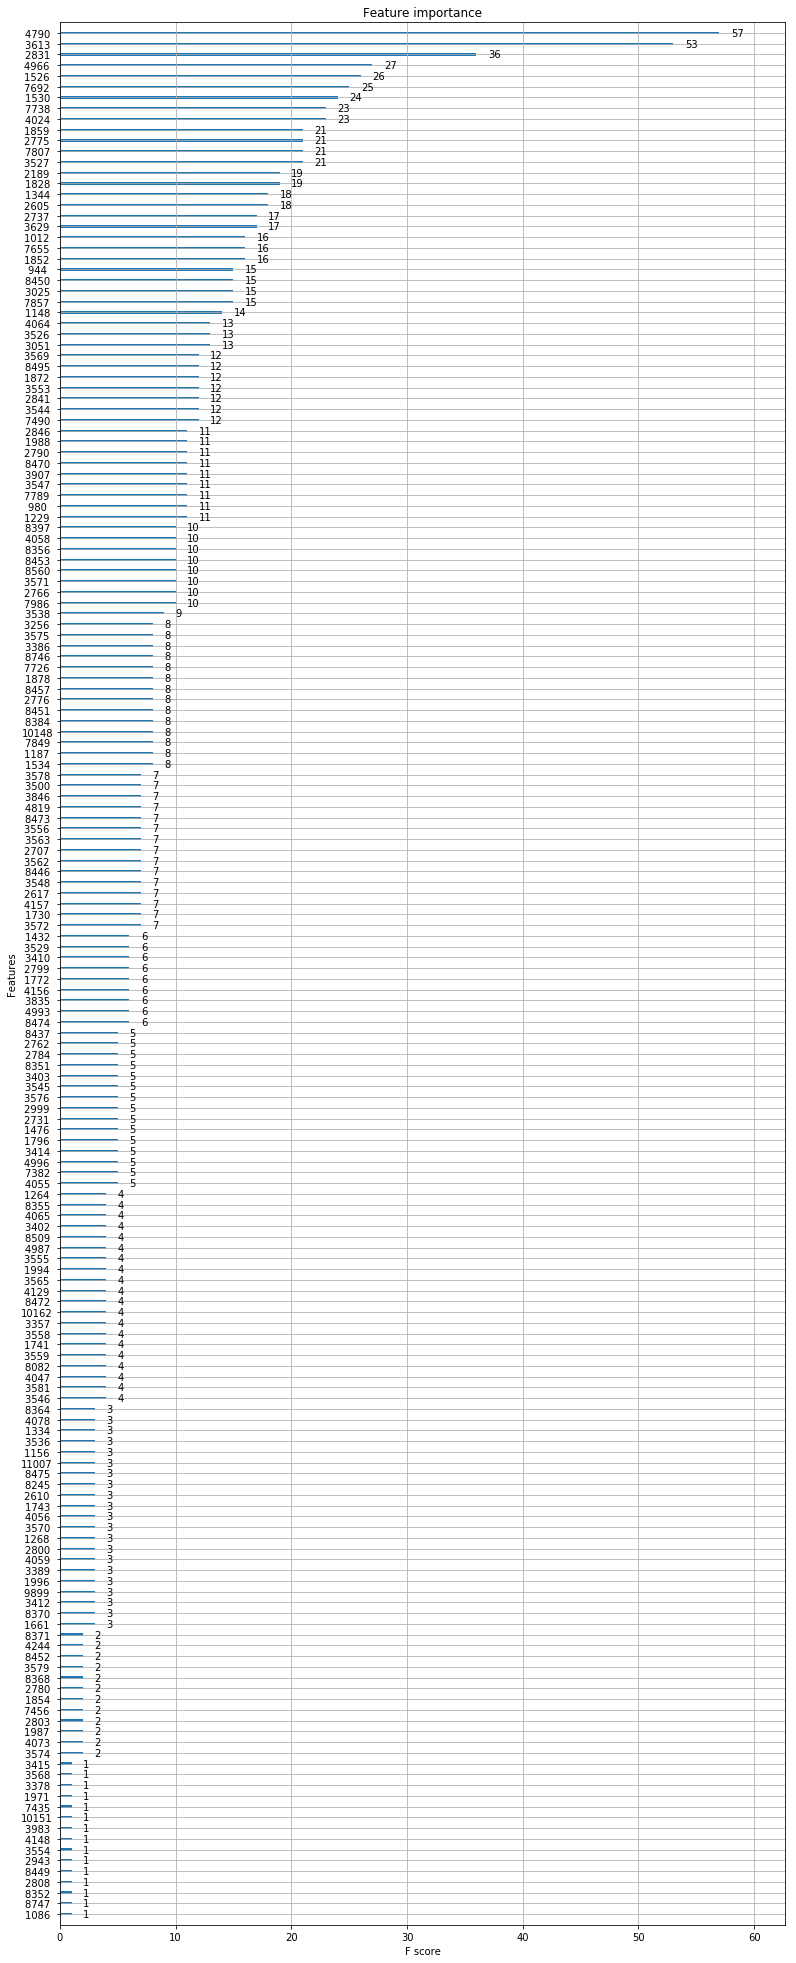

<Figure size 936x2520 with 0 Axes>

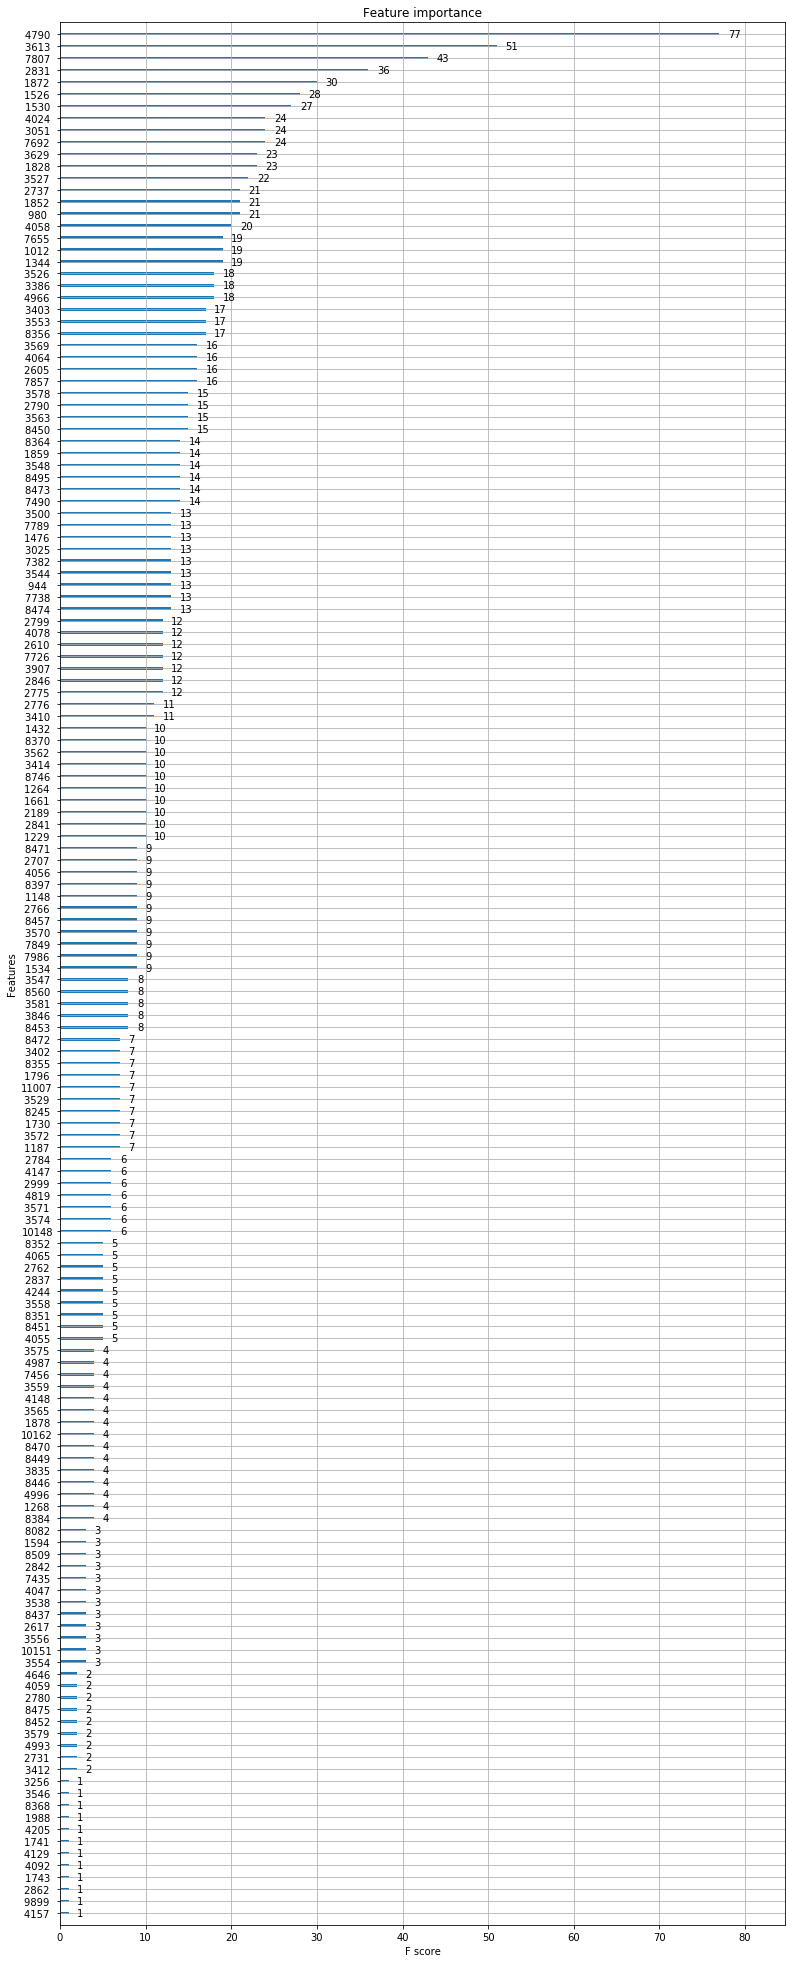

In [15]:
plt.figure(figsize=(13,35))
f,ax=plt.subplots(1,1,figsize=(13,35))
xgb.plot_importance(estimator_lat,ax=ax)
plt.figure(figsize=(13,35))
f,ax=plt.subplots(1,1,figsize=(13,35))
xgb.plot_importance(estimator_lng,ax=ax)